In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
from scipy.signal import argrelextrema
%matplotlib inline
import math
import seaborn as sns
import statsmodels.api as sm 
from patsy import dmatrices 
from sklearn.decomposition import PCA

**Importing Data/fixing length discrepancy/Converting to same timezone**

In [2]:
#Pull significant events data
sig_events_df = pd.read_csv('../Data/GDELT_data/article_counts_disasters.csv', index_col = 'datetime')
stock_df = pd.read_csv('../Data/stock_prices_cleaned.csv', index_col = 'Date')
#Convert datetime columns to appropraite dtype
sig_events_df.index = pd.to_datetime(sig_events_df.index).floor('D')
stock_df.index = pd.to_datetime(stock_df.index, utc=True).floor('D')
#Drop duplicate index column
# sig_events_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
# stock_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
#Convert stock data to UTC
print(sig_events_df)
print(stock_df)

                           All Articles  MANMADE_DISASTER_IMPLIED  \
datetime                                                            
2017-01-01 00:00:00+00:00        427906                     87559   
2017-01-02 00:00:00+00:00        592774                    109720   
2017-01-03 00:00:00+00:00        757916                    129371   
2017-01-04 00:00:00+00:00        822862                    134633   
2017-01-05 00:00:00+00:00        830028                    143110   
...                                 ...                       ...   
2022-11-06 00:00:00+00:00        166754                     30718   
2022-11-07 00:00:00+00:00        281263                     43567   
2022-11-08 00:00:00+00:00        306702                     44237   
2022-11-09 00:00:00+00:00        327495                     45854   
2022-11-10 00:00:00+00:00        288809                     43763   

                           WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE  \
datetime    

In [3]:
#Just going to drop these values to ensure dataframes are the same length/dates
print(list(set(stock_df.index) - set(sig_events_df.index)))
stock_df.drop(list(set(stock_df.index) - set(sig_events_df.index)), inplace=True)
print(len(stock_df))
#Only keep columns from GDELT that were identified with high correlation in initial analysis
#Merge Dataframes
merged_df = sig_events_df.join(stock_df, how='inner')

[Timestamp('2017-12-02 00:00:00+0000', tz='UTC'), Timestamp('2020-10-20 00:00:00+0000', tz='UTC'), Timestamp('2017-12-01 00:00:00+0000', tz='UTC')]
2137


In [4]:
#Find R2 for all tickers using MLR 
mlr_df = pd.DataFrame(np.nan,index = ['R2 Values'], columns = stock_df.columns)
ex_var = None
for ticker in stock_df.columns:
    #Generate string for MLR. Exclude the all articles column
    of_interest_events = sig_events_df.loc[:, sig_events_df.columns != 'All Articles']
    dmatrices_str = ticker + ' ~ ' 
    for i, col in enumerate(of_interest_events.columns):
        if i < len(of_interest_events.columns)-1:
            dmatrices_str += col + '+'
        else:
            dmatrices_str += col

    #MLR generation
    y_2_poly, X_2_poly = dmatrices(dmatrices_str, data=merged_df, return_type='dataframe')
    mlr_2 =sm.OLS(y_2_poly, X_2_poly).fit()
    ex_var = mlr_2
    #Save R^2 value
    mlr_df[ticker] = mlr_2.rsquared


mlr_df

,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
R2 Values,0.668287,0.552996,0.676086,0.585151,0.837638,0.706229,0.810698,0.651146


In [5]:
mlr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    JKS   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     41.43
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:26:22   Log-Likelihood:                -8050.7
No. Observations:                2135   AIC:                         1.629e+04
Df Residuals:                    2042   BIC:                         1.681e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      58.1752      1.076     54.067      0.000      56.065      60.285
MANMADE_DISASTER_IMPLIED                                       -0.0005   3.72e-05    -14.609      0.000      -0.001      -0.000
WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE  5.955e-05   1.27e-05      4.677      0.000    3.46e-05    8.45e-05
DISASTER_FIRE                                                  -0.0003      0.000     -1.445      0.149      -0.001     9.7e-05
NATURAL_DISASTER_ICE                                            0.0004      0.000      0.914      0.361      -0.000       0.001
NATURAL_DISASTER_EARTHQUAKE                                     0.0014      0.000      4.280      0.000       0.001       0.002
NATURAL_DISASTER_FLOOD                                          0.0017      0.001      2.282      0.023       0.000       0.003
NATURAL_DISASTER_FLOODING                                       0.0011      0.001      1.747      0.081      -0.000       0.002
NATURAL_DISASTER_HURRICANE                                      0.0003      0.000      1.249      0.212      -0.000       0.001
NATURAL_DISASTER_FLOODS                                         0.0031      0.001      5.042      0.000       0.002       0.004
NATURAL_DISASTER_FLOODED                                       -0.0015      0.001     -2.131      0.033      -0.003      -0.000
NATURAL_DISASTER_DROUGHT                                        0.0034      0.001      4.676      0.000       0.002       0.005
NATURAL_DISASTER_HEAVY_RAIN                                    -0.0060      0.001     -6.733      0.000      -0.008      -0.004
NATURAL_DISASTER_DROWNED                                       -0.0041      0.001     -3.965      0.000      -0.006      -0.002
NATURAL_DISASTER_EARTHQUAKES                                   -0.0025      0.001     -2.142      0.032      -0.005      -0.000
NATURAL_DISASTER_EROSION                                        0.0019      0.001      1.620      0.105      -0.000       0.004
NATURAL_DISASTER_WILDFIRE                                      -0.0039      0.001     -3.914      0.000      -0.006      -0.002
MANMADE_DISASTER_TRAFFIC_ACCIDENT                               0.0013      0.002      0.744      0.457      -0.002       0.005
NATURAL_DISASTER_TSUNAMI                                       -0.0025      0.000     -5.642      0.000      -0.003      -0.002
NATURAL_DISASTER_DROWNING                                       0.0041      0.001      2.767      0.006       0.001       0.007
NATURAL_DISASTER_NATURAL_DISASTERS                          -9.894e-05      0.001     -0.068      0.946      -0.003       0.003
NATURAL_DIS

**Standardizing/PCA before**


In [36]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

#Test most number of components
PCA_df = pd.DataFrame(columns = stock_df.columns)
for i in range(1, 92):
    #Normalize Data
    normalized_df=(sig_events_df-sig_events_df.mean())/sig_events_df.std()

    #Perform PCA

    #Generate column names depending on amount of componenets
    num_comp = i
    pca = PCA(n_components=num_comp)
    columns_arr = ['pc' + str(i) for i in range(1,num_comp+1)]
    principalComponents = pca.fit_transform(normalized_df)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = columns_arr) 
    #Set datetime index for merging later
    principalDf.index = stock_df.index
    
    merged_df = principalDf.join(stock_df, how='inner')
    
    mlr_df_PCA = pd.DataFrame(np.nan,index = ['Num Components: ' + str(i)], columns = stock_df.columns)
    ex_var = None
    for ticker in stock_df.columns:
        #Generate string for MLR. Exclude the all articles column
        of_interest_events = sig_events_df.loc[:, sig_events_df.columns != 'All Articles']
        dmatrices_str = ticker + ' ~ ' 
        for i, col in enumerate(principalDf.columns):
            if i < len(principalDf.columns)-1:
                dmatrices_str += col + '+'
            else:
                dmatrices_str += col

        #MLR generation
        y_2_poly, X_2_poly = dmatrices(dmatrices_str, data=merged_df, return_type='dataframe')
        mlr_2 =sm.OLS(y_2_poly, X_2_poly).fit()
        ex_var = mlr_2
        #Save R^2 value
        mlr_df_PCA[ticker] = mlr_2.rsquared
    #Concat result for all 8 companies with n amount of components to final dataframe
    PCA_df = pd.concat([PCA_df, mlr_df_PCA])
    
PCA_df

,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
Num Components: 1,0.062262,0.057669,0.097555,0.003245,0.465319,0.335991,0.450884,0.276993
Num Components: 2,0.074594,0.066442,0.110415,0.003245,0.579812,0.361923,0.529350,0.310394
Num Components: 3,0.090132,0.066771,0.133176,0.005802,0.602662,0.391698,0.557689,0.336022
Num Components: 4,0.090775,0.070367,0.133811,0.017449,0.602778,0.394224,0.559088,0.336719
Num Components: 5,0.094411,0.076772,0.134974,0.017845,0.629109,0.407088,0.579929,0.352887
...,...,...,...,...,...,...,...,...
Num Components: 87,0.663753,0.546699,0.669074,0.579451,0.834545,0.693798,0.804184,0.628124
Num Components: 88,0.665311,0.548441,0.671158,0.581638,0.834598,0.694224,0.805601,0.630625
Num Components: 89,0.666029,0.548496,0.673509,0.581778,0.835061,0.698574,0.807512,0.640369
Num Components: 90,0.668747,0.548630,0.677241,0.581994,0.835084,0.698585,0.807531,0.640373


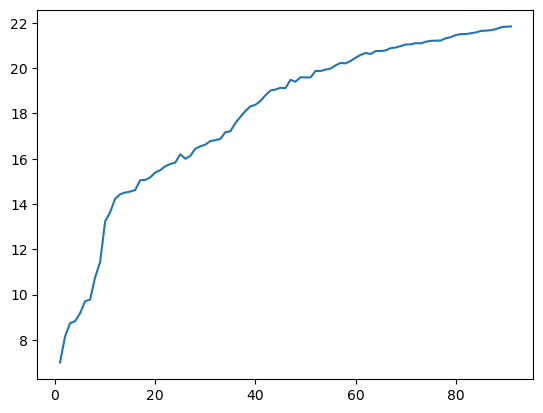

In [40]:
#Sum across rows
PCA_df['sum_r2'] = PCA_df.sum(axis=1)
#generate x-axis
x_axis = np.linspace(1,91,num = 91)

#Plot
plt.plot(x_axis, PCA_df['sum_r2'])